In [25]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 引入相依套件

In [26]:
import os

import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications.resnet50 import ResNet50, preprocess_input
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# 輸入影像與影像前處理

In [27]:
def processing_image(img_path):
    # 讀取影像為 PIL 影像
    img = image.load_img(img_path, target_size=(224, 224))

    # 轉換 PIL 影像為 nparray
    x = image.img_to_array(img)

    # 加上一個 batch size，例如轉換 (224, 224, 3) 為 （1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)

    # 將 RBG 轉換為 BGR，並解減去各通道平均
    x = preprocess_input(x)

    return x

# Grad-CAM

In [28]:
def gradcam(model, x):
    # 取得影像的分類類別
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])

    # 取得影像分類名稱
    pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]

    # 預測分類的輸出向量
    pred_output = model.output[:, pred_class]

    # 最後一層 convolution layer 輸出的 feature map
    # ResNet 的最後一層 convolution layer
    last_conv_layer = model.get_layer('conv5_block3_3_conv')

    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]

    # 求得針對每個 feature map 的梯度加總
    pooled_grads = K.sum(grads, axis=(0, 1, 2))

    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    # 計算 feature map 的 channel-wise 加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)

    return heatmap, pred_class_name

# 視覺化神經網路關注區域 - 繪製熱力圖

In [29]:
def plot_heatmap(heatmap, img_path, pred_class_name):
    # ReLU
    heatmap = np.maximum(heatmap, 0)

    # 正規化
    heatmap /= np.max(heatmap)

    # 讀取影像
    img = cv2.imread(img_path)

    fig, ax = plt.subplots()

    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)

    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)

    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)

    plt.title(pred_class_name)

    plt.show()

# 使用 Imagenet 權重視覺化分類關注區域


In [30]:
model = ResNet50(weights='imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

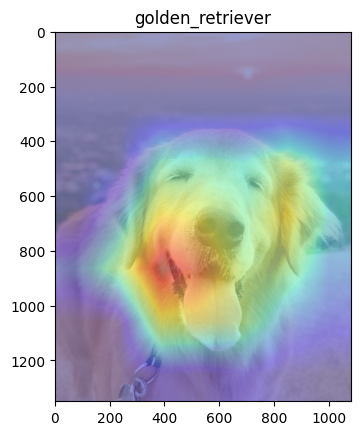

In [31]:
img_path = '/content/drive/MyDrive/Colab Notebooks/深度生成模型/WEEK2_GradCam/黃金獵犬.jpg'

img = processing_image(img_path)

heatmap, pred_class_name = gradcam(model, img)

plot_heatmap(heatmap, img_path, pred_class_name)

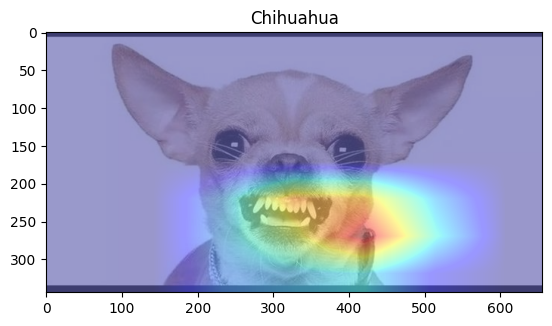

In [44]:
img_path = '/content/drive/MyDrive/Colab Notebooks/深度生成模型/WEEK2_GradCam/吉娃娃.jpg'

img = processing_image(img_path)

heatmap, pred_class_name = gradcam(model, img)

plot_heatmap(heatmap, img_path, pred_class_name)

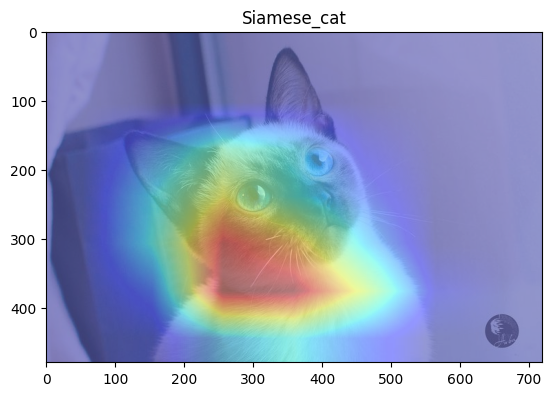

In [48]:
img_path = '/content/drive/MyDrive/Colab Notebooks/深度生成模型/WEEK2_GradCam/暹羅貓.jpg'

img = processing_image(img_path)

heatmap, pred_class_name = gradcam(model, img)

plot_heatmap(heatmap, img_path, pred_class_name)

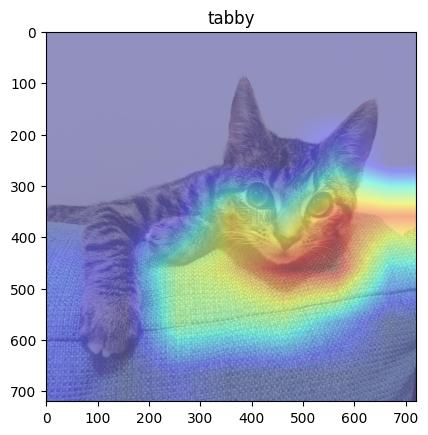

In [34]:
img_path = '/content/drive/MyDrive/Colab Notebooks/深度生成模型/WEEK2_GradCam/虎斑貓.jpg'

img = processing_image(img_path)

heatmap, pred_class_name = gradcam(model, img)

plot_heatmap(heatmap, img_path, pred_class_name)

> 參考：https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/grad-cam-introduction-d0e48eb64adb